# How Did Perceived Danger of COVID-19 Effect the Issuance of Building Permits in Mecklenburg, NC?

This file analyzes the change in building permits issued in Mecklenburg, NC and if there is a relation to masking policies in the county. It utilizes data from the [CDC](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i) for masking mandates by county, and [Mecklenburg County Open Data](https://meck-ent-power-bi-reports-public-web.azurewebsites.net/Viewer?groupId=2ca2c01c-5658-4ee2-8a4f-5bdda8be94b7&reportId=6a4603a2-d1d1-47b7-9898-3575ed3758c6) for building permits issued by the county. These datasets can be found in the data folder of this repository.

In [1]:
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

## What needs to be standardized and cleaned?
Before the analysis can start, the data needs to be loaded and cleaned. The data is also going to be filtered for Mecklenburg, NC as that is the county of interest. The CDC datafile is too large to be uploaded into the git repository, so the below cell is the code used to limit the data to Mecklenburg, NC which is in the git repository and used for the remaining analysis.

In [2]:
cdc_too_big = pd.read_csv('data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')
cdc_too_big = cdc_too_big[cdc_too_big['County_Name'].str.contains('Mecklenburg') &
                          cdc_too_big['State_Tribe_Territory'].str.contains('NC')]
cdc_too_big.to_csv('data/Mecklenburg_Mask_Mandates.csv')

Now onto the code that can be reproduced!

In [3]:
# Load the dataset
meck_mand = pd.read_csv('data/Mecklenburg_Mask_Mandates.csv')
# Filter the data for Mecklenburg
meck_mand.head()

,Unnamed: 0,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,518434,NC,Mecklenburg County,37,119,4/10/2020,2,NaN,NaN,NaN,NaN
1,518435,NC,Mecklenburg County,37,119,4/11/2020,2,NaN,NaN,NaN,NaN
2,518436,NC,Mecklenburg County,37,119,4/12/2020,2,NaN,NaN,NaN,NaN
3,518437,NC,Mecklenburg County,37,119,4/13/2020,2,NaN,NaN,NaN,NaN
4,518438,NC,Mecklenburg County,37,119,4/14/2020,2,NaN,NaN,NaN,NaN


The Face_Masks_Required_in_Public parameter is easier to work with as an integer along with a column indicating what the previous mask policy status was.

In [4]:
# Transform mask mandate data to make it easier to work with
meck_mand['prev_req'] = meck_mand['Face_Masks_Required_in_Public'].shift()
meck_mand['Face_Masks_Required_in_Public'] = np.where(meck_mand['Face_Masks_Required_in_Public'] == 'Yes',
                                                      1, -1)
meck_mand['prev_req'] = np.where(meck_mand['prev_req'] == 'Yes',
                                 1, -1)
meck_mand['mask_needed_change'] = np.where(meck_mand['Face_Masks_Required_in_Public'] == meck_mand['prev_req'],
                                           0, meck_mand['Face_Masks_Required_in_Public'])
meck_mand['date'] = pd.to_datetime(meck_mand['date'])
meck_mand.head()

,Unnamed: 0,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,prev_req,mask_needed_change
0,518434,NC,Mecklenburg County,37,119,2020-04-10,2,-1,NaN,NaN,NaN,-1,0
1,518435,NC,Mecklenburg County,37,119,2020-04-11,2,-1,NaN,NaN,NaN,-1,0
2,518436,NC,Mecklenburg County,37,119,2020-04-12,2,-1,NaN,NaN,NaN,-1,0
3,518437,NC,Mecklenburg County,37,119,2020-04-13,2,-1,NaN,NaN,NaN,-1,0
4,518438,NC,Mecklenburg County,37,119,2020-04-14,2,-1,NaN,NaN,NaN,-1,0


## Pulling building permit issuance data.
The next step is determining the date range of data that should be pulled from the Mecklenburg County Open Data tool. Looking at my prior work on Mecklenburg COVID-19 data and [how masking policies impacted new cases](https://github.com/rafrisci/data-512-project) or the below figure, Mecklenburg mask mandates were all consecutive. This allows for three distinct periods of Mecklenburg policy in regards to masking: pre-COVID, COVID, and COVID ignored.

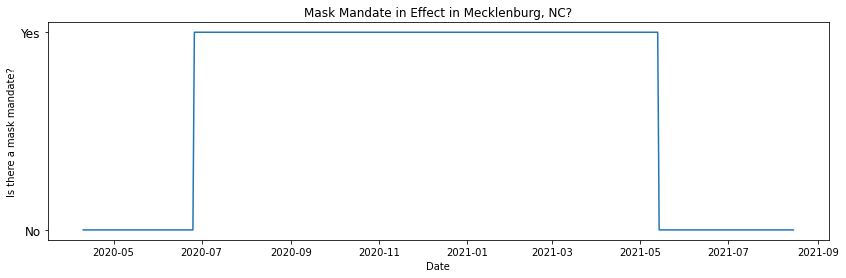

In [5]:
meck_plt = meck_mand.set_index('date')
plt.figure(figsize=(14,4))
plt.plot(meck_plt['Face_Masks_Required_in_Public'])
plt.yticks([-1, 1], ['No', 'Yes'], fontsize=12)
plt.title('Mask Mandate in Effect in Mecklenburg, NC?')
plt.xlabel('Date')
plt.ylabel('Is there a mask mandate?')
plt.savefig('visualizations/mask_mandates.jpeg')

The methodology that will be used to determine the date range for data collection is the following:
1. find the number of days mask mandates were in effect
2. get the start date by subtracting the first day of mask mandates by the number of days the mask mandate was in effect
3. get the end date by adding the last day of mask mandates by the number of days the mask mandate was in effect

This way each category will have the same number of days in their sample and the analysis will avoid imbalanced classes.

In [6]:
print("The number of days that mask mandates were in effect in Mecklenburg is",
      len(meck_mand[meck_mand['Face_Masks_Required_in_Public']==1]))
print("The mask mandate started on",
      meck_mand['date'].loc[(meck_mand['Face_Masks_Required_in_Public']==1) & (meck_mand['prev_req']==-1)].to_string(index=False))
print("The mask mandate ended on",
      meck_mand['date'].loc[(meck_mand['Face_Masks_Required_in_Public']==-1) & (meck_mand['prev_req']==1)].to_string(index=False))

The number of days that mask mandates were in effect in Mecklenburg is 322
The mask mandate started on 2020-06-26
The mask mandate ended on 2021-05-14


With the start and end date of mask mandates, we can now calculate the date range needed for the data pull.

In [7]:
print('The start date of the data pull is:',
      datetime.datetime.strptime('2020-06-26', '%Y-%m-%d') - datetime.timedelta(days=322))
print('The end date of the data pull is:',
      datetime.datetime.strptime('2021-05-14', '%Y-%m-%d') + datetime.timedelta(days=322))

The start date of the data pull is: 2019-08-09 00:00:00
The end date of the data pull is: 2022-04-01 00:00:00


The raw download of the building permit data was a .xlsx, but the version of the raw data saved in this repository is permit_issuance_raw.csv.